In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from math import pow, inf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# map a grid/action pair to the index of the corresponding q value in self.qs
three_power = np.array( [pow(3,i) for i in range(9)] )
three_power_nine = pow(3,9)
def sa_to_id(grid,action,player):
    # map grid to a 9 digit trinary number, then change the number to decimal, then add action * 3^9, finally add 9*3^9 if player is O
    flat_grid = grid.flatten()
    digits = flat_grid + 1
    multiplied = np.multiply(digits,three_power)
    index = np.sum(multiplied)
    index += three_power_nine * action
    if (player == 'O'):
        index += 177147
    return int(index)
# a version that map a batch of states to index, for efficiency
def sas_to_ids(grid,actions,player):
    flat_grid = grid.flatten()
    digits = flat_grid + 1
    multiplied = np.multiply(digits,three_power)
    s = np.sum(multiplied)
    if (player == 'O'):
        s += 177147
    ids = np.full(len(actions),s)
    for i in range(len(actions)):
        ids[i] += three_power_nine * actions[i]
    return ids.astype(int)

# Q learning agent
class QPlayer:
    '''
    the player stores the Q value of the grid/action pair when he's X as well as when he's O
    not every grid and action are valid. For example, grid where there's 3 O and zero X, or a action that place piece on existing piece.
    We keep all available grid and action never the less, for simplicity.
    '''
    def __init__(self,epsilon=0.2,player='X'):
        self.player = player
        self.qs = np.zeros(177147*2)
        self.previous_q = -1
        self.lr = 0.05
        self.d_factor = 0.99
        self.epsi = epsilon
    def set_player(self,player):
        self.player = player
    # choose action and update q value of previous s,a pair
    def act(self, grid, reward):
        #first, find all available actions
        actions = [a for a in range(9) if grid[(int(a/3), a % 3)] == 0]
        ids = sas_to_ids(grid,actions,self.player)
        possible_qs = self.qs[ids]
        #possible_qs = [self.qs[i] for i in ids]
        # get the argmax of possible qs, random tie breaking
        best = np.random.choice(np.flatnonzero(np.isclose(possible_qs, possible_qs.max())))
        #best = np.argmax(possible_qs)
        best_a = actions[ best ]
        highest_q = possible_qs[best]
        #then, update q value from previous time step
        if not self.previous_q == -1:
            delta = self.lr * (reward + self.d_factor * highest_q - self.qs[self.previous_q])
            self.qs[self.previous_q] = self.qs[self.previous_q] + delta
        #then, choose a action according to policy, and save current q value's index
        if random.uniform(0, 1) > self.epsi:
            at = best_a
        else:
            if len(actions) > 1: actions.pop(best)
            at = random.choice(actions)
        self.previous_q = sa_to_id(grid,at,self.player)
               
        return at
    # called when agent reach terminal state
    def terminal(self, reward):
        if self.previous_q == -1:
            return
        delta = self.lr * (reward + 0 - self.qs[self.previous_q])
        self.qs[self.previous_q] = self.qs[self.previous_q] + delta
        #set previous_q to -1 because game will restart
        self.previous_q = -1
    # choose a action according to q value with greedy policy, and not update any q value
    def test_act(self, grid):
        actions = [a for a in range(9) if grid[(int(a/3), a % 3)] == 0]
        ids = sas_to_ids(grid,actions,self.player)
        possible_qs = [self.qs[i] for i in ids]
        best = np.argmax(possible_qs)
        best_a = actions[ best ]
        return best_a
    def get_heat_map(self,grid):
        heat = np.zeros((3, 3))
        mask = np.full((3, 3), False)
        for ix, iy in np.ndindex(3,3):
            
            if grid[ix,iy] == 0:
                action = ix*3 + iy
                index = sa_to_id(grid,action,self.player)
                heat[ix,iy] = self.qs[index]
            else:
                mask[ix,iy] = True
        return (heat,mask)
            
        
    
# Q learning agent with decreasing epsilon 
class DecreasingQPlayer(QPlayer):
    def __init__(self,n_star, player = 'X'):
        super().__init__(player = player)
        self.epsimin = 0.1
        self.epsimax = 0.8
        self.n_star = n_star
        self.n = 0
        self.update_epsi()
    def update_epsi(self):
        self.n+=1
        second_term = self.epsimax * (1. - self.n/self.n_star)
        self.epsi = max(self.epsimin, second_term)
    def terminal(self, reward):
        super().terminal(reward)
        self.update_epsi()
        
# Q learning agent that can self practice
class SelfQPlayer(QPlayer):
    '''
    in this class self.previous_q have no actual meaning, its replaced by self.previousq_X and self.previousq_O, these record the last
    s,a pair the agent select as X or O. with a new state s', the agent will update the s that has the same player as s'
    '''
    def __init__(self,epsilon=0.2):
        super().__init__(epsilon)
        self.previous_q_X = -1
        self.previous_q_O = -1
    # the typical workflow: setplayer(X) -> act() -> setplayer(O) -> act() -> setplayer(X) -> act() -> ... -> terminal()
    def act(self, grid, reward):
        #store previous
        if self.player == 'X':
            self.previous_q = self.previous_q_X
        else:
            self.previous_q = self.previous_q_O
        at = super().act(grid,reward)
        if self.player == 'X':
            self.previous_q_X = self.previous_q
        else:
            self.previous_q_O = self.previous_q
        return at
    def terminal(self,winner):
        if winner == 'X':
            reward_X = 1
            reward_O = -1
        elif winner == 'O':
            reward_X = -1
            reward_O = 1
        else:
            reward_X = 0
            reward_O = 0
            
        if not self.previous_q_X == -1:
            delta = self.lr * (reward_X + 0 - self.qs[self.previous_q_X])
            self.qs[self.previous_q_X] = self.qs[self.previous_q_X] + delta
        if not self.previous_q_O == -1:
            delta = self.lr * (reward_O + 0 - self.qs[self.previous_q_O])
            self.qs[self.previous_q_O] = self.qs[self.previous_q_O] + delta
        #set previous_q to -1 because game will restart
        self.previous_q_X = -1
        self.previous_q_O = -1

# Q learning agent that can self practice with decreasing epsilon
class DecreasingSelfQPlayer(QPlayer):
    '''
    in this class self.previous_q have no actual meaning, its replaced by self.previousq_X and self.previousq_O, these record the last
    s,a pair the agent select as X or O. with a new state s', the agent will update the s that has the same player as s'
    '''
    def __init__(self,n_star):
        super().__init__()
        self.previous_q_X = -1
        self.previous_q_O = -1
        self.epsimin = 0.1
        self.epsimax = 0.8
        self.n_star = n_star
        self.n = 0
        self.update_epsi()
    def update_epsi(self):
        self.n+=1
        second_term = self.epsimax * (1. - self.n/self.n_star)
        self.epsi = max(self.epsimin, second_term)
    # the typical workflow: setplayer(X) -> act() -> setplayer(O) -> act() -> setplayer(X) -> act()...
    def act(self, grid, reward):
        #store previous
        if self.player == 'X':
            self.previous_q = self.previous_q_X
        else:
            self.previous_q = self.previous_q_O
        at = super().act(grid,reward)
        if self.player == 'X':
            self.previous_q_X = self.previous_q
        else:
            self.previous_q_O = self.previous_q
        return at
    def terminal(self,winner):
        if winner == 'X':
            reward_X = 1
            reward_O = -1
        elif winner == 'O':
            reward_X = -1
            reward_O = 1
        else:
            reward_X = 0
            reward_O = 0
            
        if not self.previous_q_X == -1:
            delta = self.lr * (reward_X + 0 - self.qs[self.previous_q_X])
            self.qs[self.previous_q_X] = self.qs[self.previous_q_X] + delta
        if not self.previous_q_O == -1:
            delta = self.lr * (reward_O + 0 - self.qs[self.previous_q_O])
            self.qs[self.previous_q_O] = self.qs[self.previous_q_O] + delta
        #set previous_q to -1 because game will restart
        self.previous_q_X = -1
        self.previous_q_O = -1
        self.update_epsi()

# compatible input: QPlayer, DecreasingQPlayer, SelfQPlayer, DecreasingSelfQPlayer
def measure(player_pi,opt = True):
    env = TictactoeEnv()
    if opt:
        player_opt = OptimalPlayer(epsilon=0.)
    else:
        player_opt = OptimalPlayer(epsilon = 1.)
    num_lose = 0
    num_win = 0
    for i in range(500):
        #each game
        #random.seed(i)
        env.reset()
        grid, _, __ = env.observe()
        if (i<250):
            player_opt.set_player('O')
            player_pi.set_player('X')
        else:
            player_opt.set_player('X')
            player_pi.set_player('O')
        for j in range(9):
            #each move
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = player_pi.test_act(grid)
            grid, end, winner = env.step(move, print_grid=False)
            if end:
                if winner == player_pi.player: num_win += 1
                if winner == player_opt.player: num_lose += 1
                break
    return (num_win - num_lose)/500

#compatable input: QPlayer, DecreasingQPlayer
def train(epsi_opt,player_q,ms = False):# ms stands for measure
    env = TictactoeEnv()
    turns = np.array(['X','O'])
    player_opt = OptimalPlayer(epsilon=epsi_opt)
    average_rewards = []
    period_rewards = []
    if ms:
        m_opt = []
        m_rand = []
    for i in tqdm(range(20000)):
        #each game
        env.reset()
        grid, _, __ = env.observe()
        turns = turns[[1,0]]
        player_opt.set_player(turns[0])
        player_q.set_player(turns[1])
        for j in range(9):
            #each move
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = player_q.act(grid,0)

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                if winner == player_q.player: reward = 1
                elif winner == player_opt.player: reward = -1
                else: reward = 0
                player_q.terminal(reward)
                break
        period_rewards.append(reward)               
        if i%250 == 249:
            average_rewards.append(np.mean(period_rewards))
            period_rewards = []
            if ms:
                m_opt.append(measure(player_q))
                m_rand.append(measure(player_q, False))
    if ms:
        return {
            'average rewards':average_rewards,
            'm opt':m_opt,
            'm rand':m_rand
        }
    else:
        return average_rewards

#compatible input: SelfQPlayer, DecreasingSelfQPlayer
def self_train(player_q, ms = True):
    env = TictactoeEnv()
    m_opt = []
    m_rand = []
    for i in tqdm(range(20000)):
        #each game
        env.reset()
        grid, _, __ = env.observe()
        for j in range(9):
            #each move
            player_q.set_player(env.current_player)
            move = player_q.act(grid,0)

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                player_q.terminal(winner)
                break
        if i%250 == 249 and ms:
            m_opt.append(measure(player_q))
            m_rand.append(measure(player_q, False))

    return {
        'm opt':m_opt,
        'm rand':m_rand
    }



## 2.1 Learning from Experts
### Question1

In [43]:
player_q = QPlayer(epsilon= 0.5)
average_rewards = train(0.5,player_q)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:50<00:00, 395.51it/s]


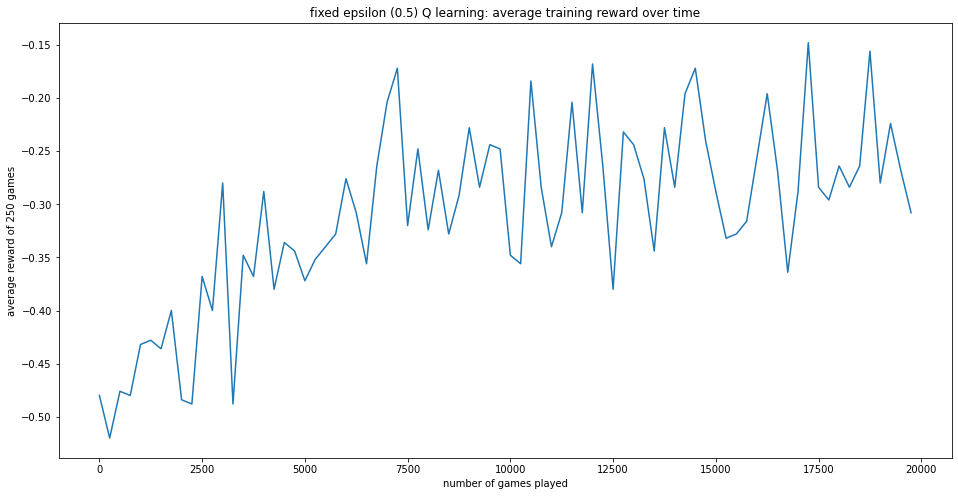

In [55]:
fig,ax = plt.subplots(figsize = (16,8))
ax.plot(np.arange(len(average_rewards))*250,average_rewards)
ax.set_ylabel('average reward of 250 games')
ax.set_xlabel('number of games played')
ax.set_title("fixed epsilon (0.5) Q learning: average training reward over time")
plt.savefig('q_learning_figures/Q1.png')

Yes, the agent learnt to play tictactoe to some extent, but not very well. I choose epsilon to be 0.5

## 2.1.1 Decreasing Exploration
### question2

In [56]:
n_stars = [1,10000,20000,30000,40000]
decreasing_players = [DecreasingQPlayer(ns) for ns in n_stars]
results = [train(0.5, player, True) for player in decreasing_players]

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:52<00:00, 86.08it/s]


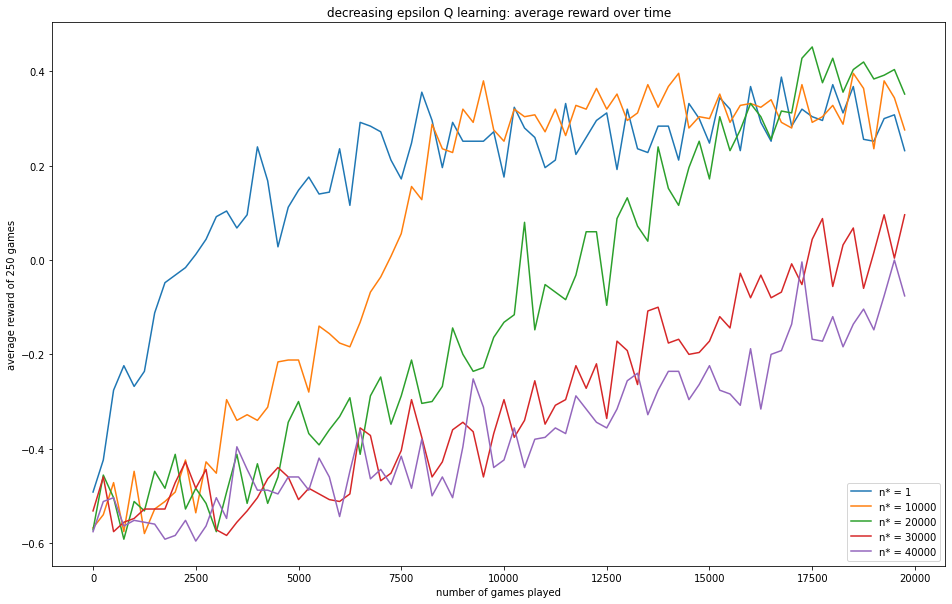

In [60]:
rewards = [r['average rewards'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for reward, ns in zip(rewards,n_stars):
    ax.plot(np.arange(len(reward))*250, reward ,label = 'n* = {}'.format(ns))
ax.set_title("decreasing epsilon Q learning: average reward over time")
ax.set_ylabel('average reward of 250 games')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q2.png')

Decreasing n\* does help with training if n\* is choosed correctly. When n\* = 10000, the average reward reached a steady 0.4 comparing with -0.3 when epsilon is fixed.

Epsilon will start at epsilon max, then reduce to epsilon min over the course of roughly n\* games, after that it will be fixed at epsilon min. In other words, the agent change from high exploration to high exploitation over n\* games. The more exploration the agent does, the more informed it will be, the more exploitation it does, the better reward it get with his current information.

As a result of the change, we see a steadily increasing reward over n\* games. Then reward remain rather constant, and its level depends on how many exploration the agent has previously did, e.g. n\*=10000's constant reward is higher than when n\* is 1. Because the latter has done close to zero exploration

### Question3

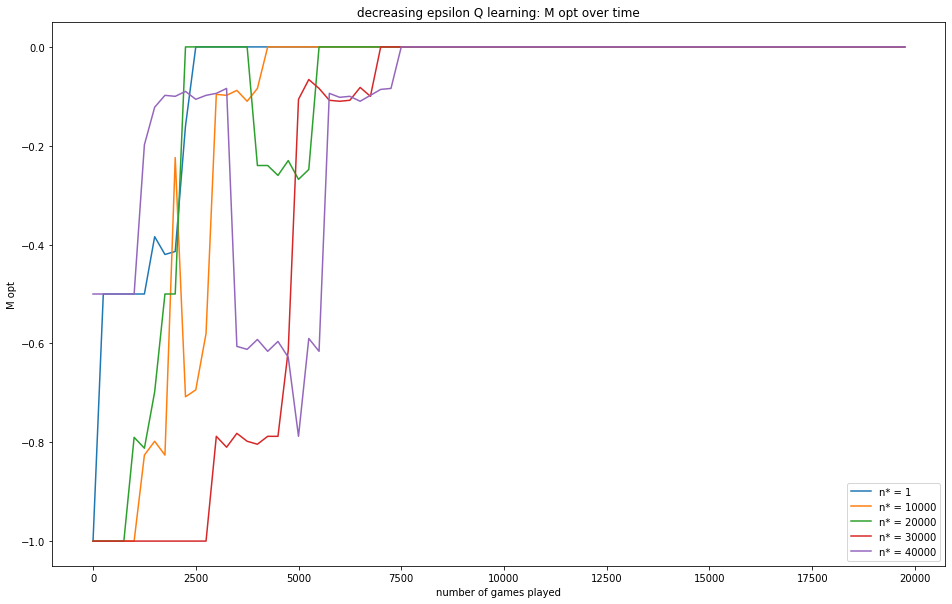

In [64]:
m_optimals = [r['m opt'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for mopt, ns in zip(m_optimals,n_stars):
    ax.plot(np.arange(len(mopt))*250, mopt ,label = 'n* = {}'.format(ns))
ax.set_title("decreasing epsilon Q learning: M opt over time")
ax.set_ylabel('M opt')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q3_1.png')

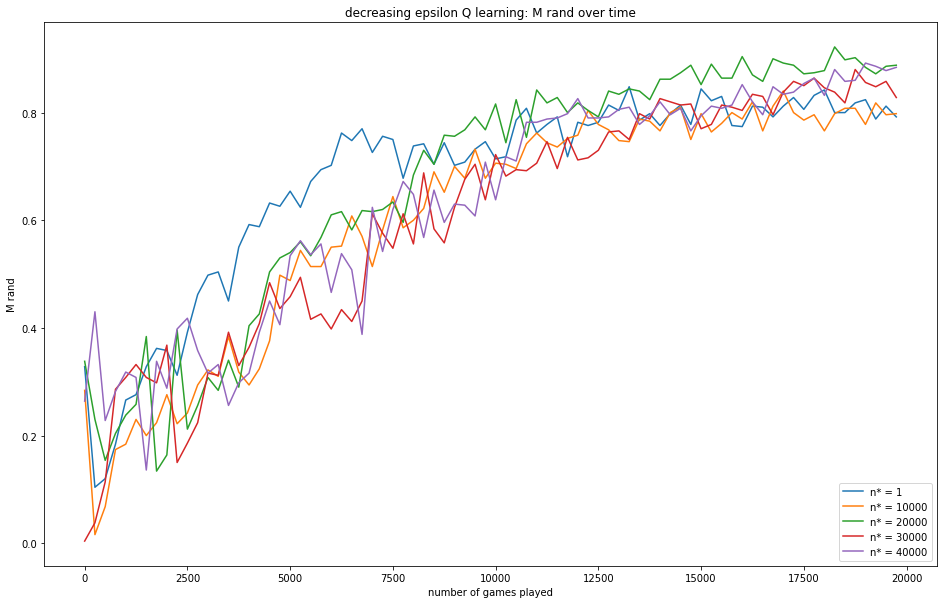

In [66]:
m_randoms = [r['m rand'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for mrand, ns in zip(m_randoms,n_stars):
    ax.plot(np.arange(len(mrand))*250, mrand ,label = 'n* = {}'.format(ns))
ax.set_title("decreasing epsilon Q learning: M rand over time")
ax.set_ylabel('M rand')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q3_2.png')

M rand over time has similar shapes to average reward over time. But its value tipically goes from 0 to 1. While M opt over time tends to have a sudden jump from -1 to 0, and stays 0 there from then on.

## 2.1.2 Good Expert and Bad Expert
### Question 4

In [67]:
best_ns = 20000
epsi_opts = [0.,0.25,0.5,0.75,1.]
good_bad_players = []
results = []
for e in epsi_opts:
    p = DecreasingQPlayer(best_ns)
    good_bad_players.append(p)
    r = train(e,p,True)
    results.append(r)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:07<00:00, 106.60it/s]


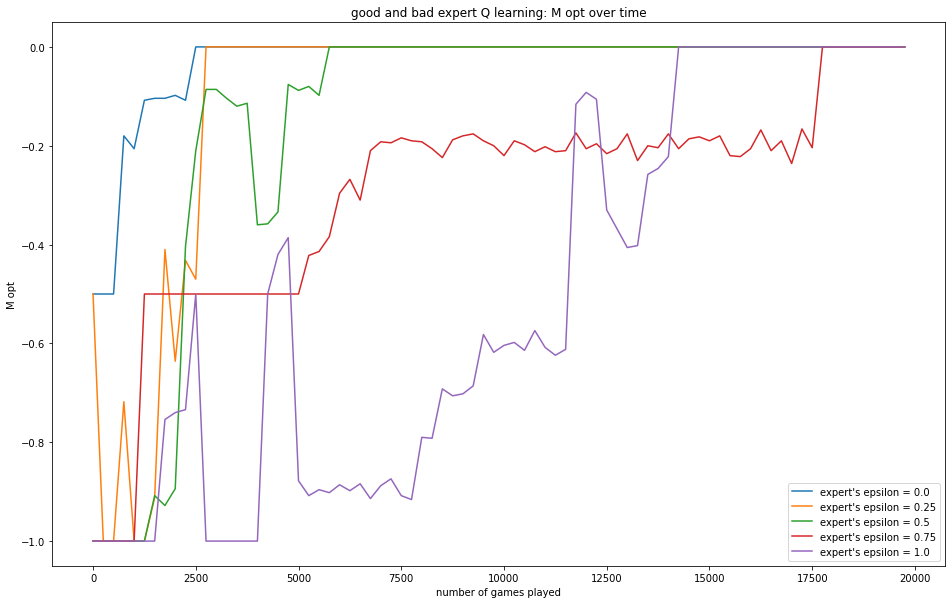

In [69]:
m_optimals = [r['m opt'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for mopt, epsi in zip(m_optimals,epsi_opts):
    ax.plot(np.arange(len(mopt))*250, mopt ,label = "expert's epsilon = {}".format(epsi))
ax.set_title("good and bad expert Q learning: M opt over time")
ax.set_ylabel('M opt')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q4_1.png')

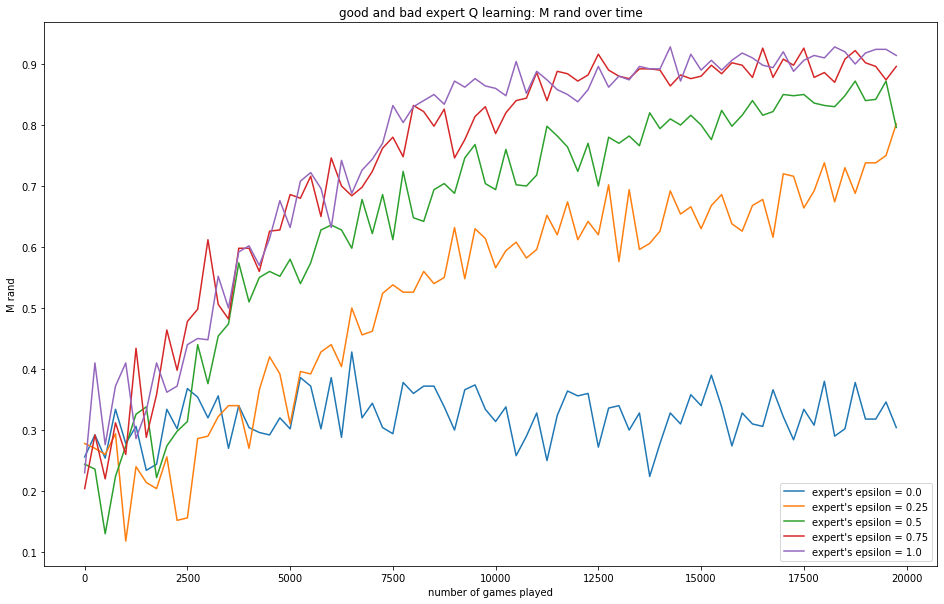

In [71]:
m_randoms = [r['m rand'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for mrand, epsi in zip(m_randoms,epsi_opts):
    ax.plot(np.arange(len(mrand))*250, mrand ,label = "expert's epsilon = {}".format(epsi))
ax.set_title("good and bad expert Q learning: M rand over time")
ax.set_ylabel('M rand')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q4_2.png')

When trained against good expert, M opt gets to 0 faster, and M rand stays considerably low. When trained against bad expert, M opt get to 0 very late, but M rand is high. That's because agent always learn to get the maximum reward in its training setting.
### question 5


In [73]:
last_mo = [mo[-1] for mo in m_optimals]
last_mr = [mr[-1] for mr in m_randoms]
i1 = np.argmax(last_mo)
i2 = np.argmax(last_mr)
print("the best M opt after 20000 games is {}, when expert's epsilon is set to {}".format(last_mo[i1],epsi_opts[i1]))
print("the best M rand after 20000 games is {}, when expert's epsilon is set to {}".format(last_mr[i2],epsi_opts[i2]))

the best M opt after 20000 games is 0.0, when expert's epsilon is set to 0.0
the best M rand after 20000 games is 0.914, when expert's epsilon is set to 1.0




### question 6
No, because the two agents are trained by playing against different player. Their learnt Q value must therefore have different meaning. In particular, agent 1 's Q value is the expected total reward playing against Opt(0), and agent 2's Q value is the expected total reward playing against Opt(1). For instance, agent 1 may have a high Q-value for blocking action, and agent 2 may not, because his opponent is only a random player
## 2.2 Learning by Self Practice
### Question 7

In [74]:
epsilons = [0.,0.25,0.5,0.75]
self_players = [SelfQPlayer(e) for e in epsilons]
results = [self_train(p) for p in self_players]

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:27<00:00, 96.37it/s]


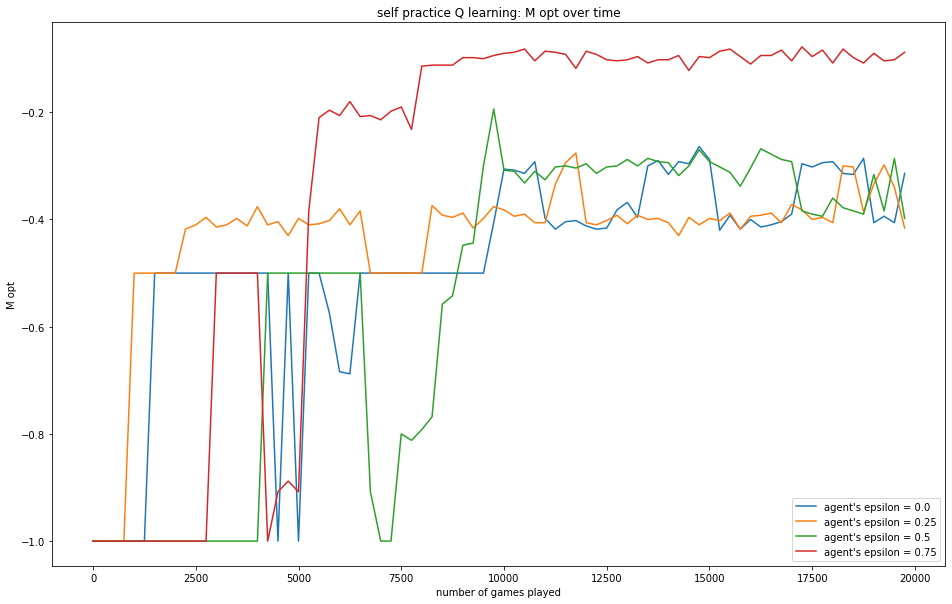

In [75]:
m_optimals = [r['m opt'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for mopt, epsi in zip(m_optimals,epsilons):
    ax.plot(np.arange(len(mopt))*250, mopt ,label = "agent's epsilon = {}".format(epsi))
ax.set_title("self practice Q learning: M opt over time")
ax.set_ylabel('M opt')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q7_1.png')

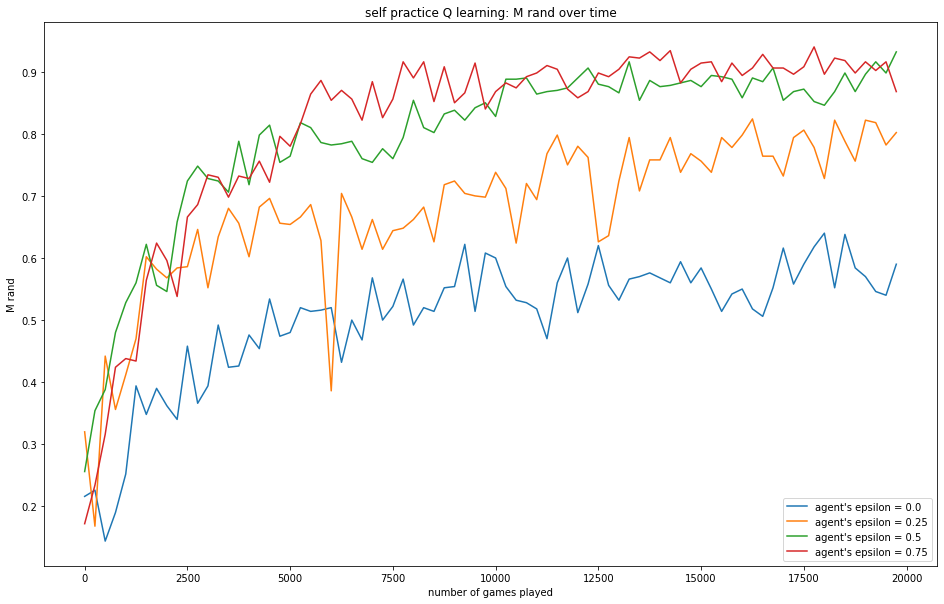

In [77]:
m_randoms = [r['m rand'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for mrand, epsi in zip(m_randoms,epsilons):
    ax.plot(np.arange(len(mrand))*250, mrand ,label = "agent's epsilon = {}".format(epsi))
ax.set_title("self practice Q learning: M rand over time")
ax.set_ylabel('M rand')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q7_2.png')

Generally, the higher epsilon a agent has, the better its performance is against M opt and M rand. However, M opt couldn't get to 0 in any case.

### Question 8

In [106]:
n_stars = [1,10000,20000,30000,40000]
decreasing_self_players = [DecreasingSelfQPlayer(ns) for ns in n_stars]
results = [self_train(p) for p in decreasing_self_players]

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:51<00:00, 86.38it/s]


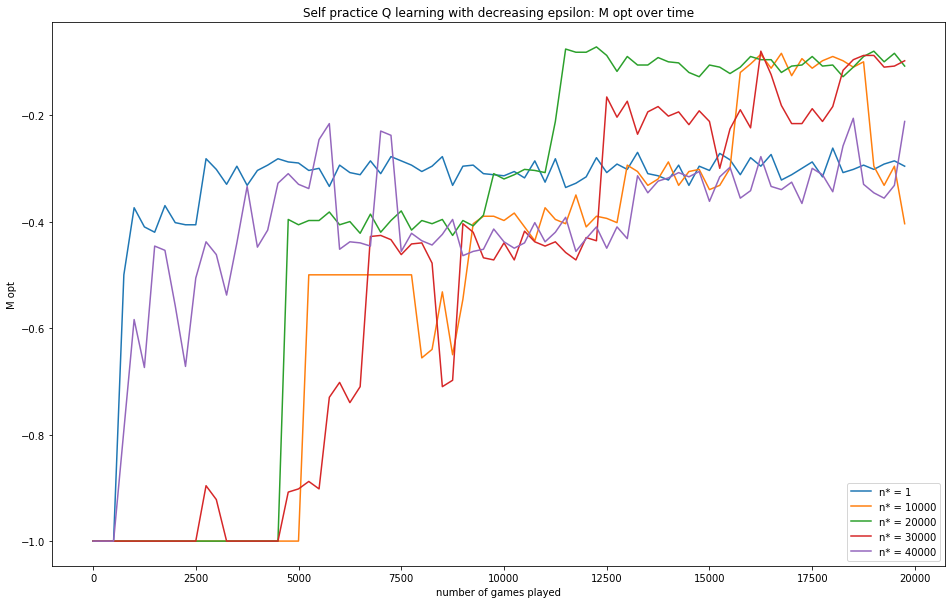

In [107]:
m_optimals = [r['m opt'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for mopt, ns in zip(m_optimals,n_stars):
    ax.plot(np.arange(len(mopt))*250, mopt ,label = 'n* = {}'.format(ns))
ax.set_title("Self practice Q learning with decreasing epsilon: M opt over time")
ax.set_ylabel('M opt')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q8_1.png')

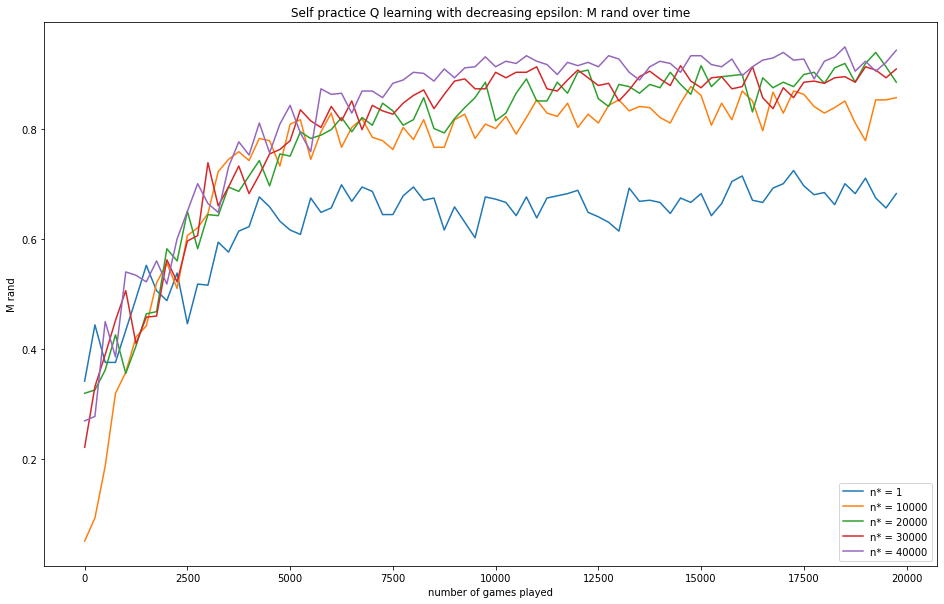

In [108]:
m_randoms = [r['m rand'] for r in results]
fig, ax = plt.subplots(figsize=(16, 10))
for mrand, ns in zip(m_randoms,n_stars):
    ax.plot(np.arange(len(mrand))*250, mrand ,label = 'n* = {}'.format(ns))
ax.set_title("Self practice Q learning with decreasing epsilon: M rand over time")
ax.set_ylabel('M rand')
ax.set_xlabel('number of games played')
ax.legend(loc='lower right')
plt.savefig('q_learning_figures/Q8_2.png')

Decreasing epsilon does help with training. Generally, the higher n\* a agent has,the better its performance will be. This is true for n\* lower than 20000. When n\* higher than 20000, there's no noticable difference.

### Question 9


In [109]:
last_mo = [mo[-1] for mo in m_optimals]
last_mr = [mr[-1] for mr in m_randoms]
i1 = np.argmax(last_mo)
i2 = np.argmax(last_mr)
print("the best M opt after 20000 games is {}, when n star is set to {}".format(last_mo[i1],n_stars[i1]))
print("the best M rand after 20000 games is {}, when n star is set to {}".format(last_mr[i2],n_stars[i2]))

the best M opt after 20000 games is -0.098, when n star is set to 30000
the best M rand after 20000 games is 0.942, when n star is set to 40000


Through my observation n\* = 30000 is the best choice. M opt reaches 0, and M rand reaches 0.9 in this case

### Question 10

In [3]:
import seaborn as sns

In [4]:
grid1 = np.array([[ 0.,  1.,  1.],
                  [ 0., -1.,  0.],
                  [ 0.,  0.,  0.]])

grid2 = np.array([[-1., -1.,  1.],
                  [ 0.,  1.,  0.],
                  [ 0.,  0.,  0.]])

grid3 = np.array([[ 0.,  1.,  1.],
                  [-1., -1.,  0.],
                  [ 0.,  1.,  0.]])
                 
def grid_to_text(grid):
    text = np.empty((3,3),dtype='str')
    for ix, iy in np.ndindex(3,3):
        if (grid[ix,iy] == 1): 
            text[ix,iy]="X"
        if (grid[ix,iy] == -1): 
            text[ix,iy]="O"
    return text

my_player = DecreasingSelfQPlayer(30000)
self_train(my_player,False);

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:06<00:00, 302.38it/s]


{'m opt': [], 'm rand': []}

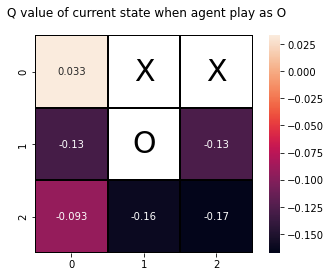

In [36]:
my_player.set_player("O")
heat, mask = my_player.get_heat_map(grid1)
text = grid_to_text(grid1)
fig, ax = plt.subplots()
ax = sns.heatmap(heat, mask=mask,square = True,linewidths=0.01, linecolor='k', annot = True )
for ix, iy in np.ndindex(3,3):
    ax.text(iy+0.5, ix+0.5, text[ix,iy],fontsize=30,horizontalalignment='center',verticalalignment='center')
fig.suptitle("Q value of current state when agent play as O")
fig.savefig("q_learning_figures/Q10_1.png") 

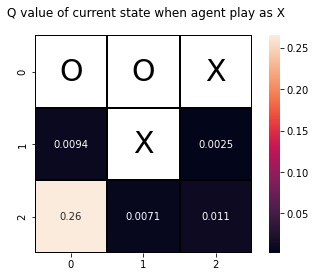

In [37]:
my_player.set_player("X")
heat, mask = my_player.get_heat_map(grid2)
text = grid_to_text(grid2)
fig, ax = plt.subplots()
ax = sns.heatmap(heat, mask=mask,square = True,linewidths=0.01, linecolor='k', annot = True )
for ix, iy in np.ndindex(3,3):
    ax.text(iy+0.5, ix+0.5, text[ix,iy],fontsize=30,horizontalalignment='center',verticalalignment='center')
fig.suptitle("Q value of current state when agent play as X")
fig.savefig("q_learning_figures/Q10_2.png") 

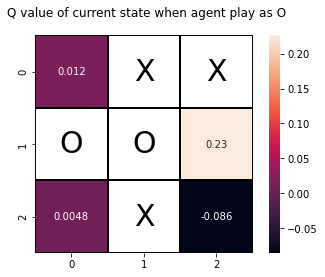

In [38]:
my_player.set_player("O")
heat, mask = my_player.get_heat_map(grid3)
text = grid_to_text(grid3)
fig, ax = plt.subplots()
ax = sns.heatmap(heat, mask=mask,square = True,linewidths=0.01, linecolor='k', annot = True )
for ix, iy in np.ndindex(3,3):
    ax.text(iy+0.5, ix+0.5, text[ix,iy],fontsize=30,horizontalalignment='center',verticalalignment='center')
fig.suptitle("Q value of current state when agent play as O")
fig.savefig("q_learning_figures/Q10_3.png") 